# The file is an analysis of the preliminary $\alpha_{\textrm{CE}}$ variation run following the methods in the tutorial from the compas repo.

In [1]:
import os
import sys
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.gridspec as gridspec
import h5py as h5
import astropy.units as u
import warnings

from matplotlib import rc
from KDEpy import FFTKDE  # Fastest 1D algorithm
from   astropy.cosmology import WMAP9 as cosmology
from scipy import stats
from   scipy.optimize import newton

# Import COMPAS root directory and set data
compasRootDir   = '/Users/adamboesky/Research/PRISE/COMPAS'

# Import COMPAS specific scripts
sys.path.append(compasRootDir + '/utils/CosmicIntegration/')
sys.path.append(os.getcwd() + '/Scripts')
import ClassCOMPAS, ClassMSSFR, ClassCosmicIntegrator 
import FastCosmicIntegration as FCI 
import selection_effects

# Magic function to set the backend of matplotlib to the 'inline' backend
%matplotlib inline

#Set latex environment for plots/labels
matplotlib.rc('font', **{'family': 'sans-serif'})
matplotlib.rc('text', usetex=True)
matplotlib.rcParams['text.latex.preamble'] = [r'\boldmath']
plt.rc('font', family='serif')

/var/folders/2f/vnb6fr7n7g32fwlgp_k3l3sc0000gn/T/ipykernel_49505/1884899081.py:34: MatplotlibDeprecationWarning: Support for setting an rcParam that expects a str value to a non-str value is deprecated since 3.5 and support will be removed two minor releases later.
  matplotlib.rcParams['text.latex.preamble'] = [r'\boldmath']


# 1. Create Compas data objects
##  a) Condense the each of the batch's outputs into one h5 file
Function that combines all of the h5 files from each batch. It will write and return the complete h5 file

In [14]:
def condense_h5s(output_dir):

    index = 0 # A useful variable for indexing through the files in the output directory

    # Iterate through the files in the output directory
    for dir in os.listdir(output_dir):
        
        # Make sure that the directories are from the batches
        if dir[0:5] == 'batch':
            batch_num = dir [-1]
            f_h5 = h5.File(output_dir + '/batch_' + batch_num + '/batch_' + batch_num + '.h5', 'r')
            
            # If it's the first batch directory, create an h5 file and copy the first batch's contents into it
            if index == 0:
                # Create an h5 file to put all of the batch's h5 files in
                complete_h5 = h5.File(output_dir + '/complete.h5', 'w')

                # Create and copy the first batch's h5 file into the complete_h5 file
                # DCOs = complete_h5.create_group('BSE_Double_Compact_Objects')
                for group in f_h5.keys():
                    # complete_h5.create_group(group)
                    f_h5.copy(f_h5[group], complete_h5)
                
                DCOs = complete_h5['BSE_Double_Compact_Objects']
                CEs = complete_h5['BSE_Common_Envelopes']
                RLOFs = complete_h5['BSE_RLOF']
                SNs = complete_h5['BSE_Supernovae']
                SPs = complete_h5['BSE_System_Parameters']
                RDs = complete_h5['Run_Details']
                
            # If it's not the first directory, append the new data to each group in the complete h5 file
            else:
                # Append new data to it
                for key in DCOs.keys():
                    DCOs[key].resize((DCOs[key].shape[0] + f_h5['BSE_Double_Compact_Objects'][key].shape[0]), axis=0)
                    DCOs[key][-f_h5['BSE_Double_Compact_Objects'][key].shape[0]:] = f_h5['BSE_Double_Compact_Objects'][key]
                
                for key in CEs.keys():
                    CEs[key].resize((CEs[key].shape[0] + f_h5['BSE_Common_Envelopes'][key].shape[0]), axis=0)
                    CEs[key][-f_h5['BSE_Common_Envelopes'][key].shape[0]:] = f_h5['BSE_Common_Envelopes'][key]
                
                for key in RLOFs.keys():
                    RLOFs[key].resize((RLOFs[key].shape[0] + f_h5['BSE_RLOF'][key].shape[0]), axis=0)
                    RLOFs[key][-f_h5['BSE_RLOF'][key].shape[0]:] = f_h5['BSE_RLOF'][key]
                
                for key in SNs.keys():
                    SNs[key].resize((SNs[key].shape[0] + f_h5['BSE_Supernovae'][key].shape[0]), axis=0)
                    SNs[key][-f_h5['BSE_Supernovae'][key].shape[0]:] = f_h5['BSE_Supernovae'][key]
                
                for key in SPs.keys():
                    SPs[key].resize((SPs[key].shape[0] + f_h5['BSE_System_Parameters'][key].shape[0]), axis=0)
                    SPs[key][-f_h5['BSE_System_Parameters'][key].shape[0]:] = f_h5['BSE_System_Parameters'][key]
                
                for key in RDs.keys():
                    RDs[key].resize((RDs[key].shape[0] + f_h5['Run_Details'][key].shape[0]), axis=0)
                    RDs[key][-f_h5['Run_Details'][key].shape[0]:] = f_h5['Run_Details'][key]

            index+=1 # Update the index
            f_h5.close() # Close the batch file

    complete_h5.close() # Close the complete h5 file
    return output_dir + '/complete.h5'

Condense all .h5 file outputs for the common envelope alpha values

In [15]:
alpha_vals = ['0.1', '0.5', '2.0', '10.0'] # All the alpha values
beta_vals = ['0.25', '0.5', '0.75'] # All the beta values

condensed_paths = {} # 2D dictionary holding the paths to the output h5 files for which the first dimension is the alpha CE value and the second is the beta value

for alpha in alpha_vals:
    condensed_paths[alpha] = {}
    for beta in beta_vals:
        condensed_paths[alpha][beta] = condense_h5s('/Users/adamboesky/Research/PRISE/exploring_parameter_space/Data/output_alpha_CE_beta/alpha_CE_' + alpha + '_beta_' + beta)

*** To use if the h5 files have already been condensed! ***

In [2]:
alpha_vals = ['0.1', '0.5', '2.0', '10.0'] # All the alpha values
beta_vals = ['0.25', '0.5', '0.75'] # All the beta values

condensed_paths = {} # 2D dictionary holding the paths to the output h5 files for which the first dimension is the alpha CE value and the second is the beta value

for alpha in alpha_vals:
    condensed_paths[alpha] = {}
    for beta in beta_vals:
        condensed_paths[alpha][beta] = '/Users/adamboesky/Research/PRISE/exploring_parameter_space/Data/output_alpha_CE_beta/alpha_CE_' + alpha + '_beta_' + beta + '/complete.h5'

## b) Create COMPASData objects for each of the $\alpha_{\textrm{CE}}$ and $\beta$ values

In [3]:
# For now, assume all the defaults and just set the paths for each value
data = {} # 2D dictionary in which the first dimension is the alpha CE value and the second is the beta value
for alpha_index, alpha_val in enumerate(alpha_vals):
    data[alpha_val] = {}
    for beta_index, beta_val in enumerate(beta_vals):
        data[alpha_val][beta_val] = ClassCOMPAS.COMPASData(path=condensed_paths[alpha_val][beta_val])


ClassCOMPAS: Remember to self.setCOMPASDCOmask()
                    then self.setCOMPASData()
          and optionally self.setGridAndMassEvolved() if using a metallicity grid
ClassCOMPAS: Remember to self.setCOMPASDCOmask()
                    then self.setCOMPASData()
          and optionally self.setGridAndMassEvolved() if using a metallicity grid
ClassCOMPAS: Remember to self.setCOMPASDCOmask()
                    then self.setCOMPASData()
          and optionally self.setGridAndMassEvolved() if using a metallicity grid
ClassCOMPAS: Remember to self.setCOMPASDCOmask()
                    then self.setCOMPASData()
          and optionally self.setGridAndMassEvolved() if using a metallicity grid
ClassCOMPAS: Remember to self.setCOMPASDCOmask()
                    then self.setCOMPASData()
          and optionally self.setGridAndMassEvolved() if using a metallicity grid
ClassCOMPAS: Remember to self.setCOMPASDCOmask()
                    then self.setCOMPASData()
          and option

In [4]:
counter = 0
for alpha, beta_dict in data.items():
    for beta, compas_data in beta_dict.items():
        compas_data.Mlower = 5
        compas_data.Mupper = 150
        compas_data.binaryFraction = 1.0
        compas_data.setGridAndMassEvolved()
    print('Finished ', counter, 'set of beta values')
    counter+=1


## c) Check the number of each type of system in the runs

In [36]:
for alpha, beta_dict in data.items():
    for beta, compas_data in beta_dict.items():
        compas_data.setCOMPASDCOmask(types='BBH', pessimistic=True)
        
        #Check if we have any system meeting the criteria
        print('Number of BBH systems at alpha_CE = {alpha} and beta = {beta}'.format(alpha=float(alpha), beta=float(beta)), np.sum(compas_data.DCOmask))

print('')

for alpha, beta_dict in data.items():
    for beta, compas_data in beta_dict.items():
        compas_data.setCOMPASDCOmask(types='BNS', pessimistic=True)
        
        #Check if we have any system meeting the criteria
        print('Number of BNS systems at alpha_CE = {alpha} and beta = {beta}'.format(alpha=float(alpha), beta=float(beta)), np.sum(compas_data.DCOmask))

print('')

for alpha, beta_dict in data.items():
    for beta, compas_data in beta_dict.items():
        compas_data.setCOMPASDCOmask(types='BHNS', pessimistic=True)
        
        #Check if we have any system meeting the criteria
        print('Number of BHNS systems at alpha_CE = {alpha} and beta = {beta}'.format(alpha=float(alpha), beta=float(beta)), np.sum(compas_data.DCOmask))

Number of BBH systems at alpha_CE = 0.1 and beta = 0.25 61805
Number of BBH systems at alpha_CE = 0.1 and beta = 0.5 61020
Number of BBH systems at alpha_CE = 0.1 and beta = 0.75 102579
Number of BBH systems at alpha_CE = 0.5 and beta = 0.25 122996
Number of BBH systems at alpha_CE = 0.5 and beta = 0.5 137105
Number of BBH systems at alpha_CE = 0.5 and beta = 0.75 149897
Number of BBH systems at alpha_CE = 2.0 and beta = 0.25 196674
Number of BBH systems at alpha_CE = 2.0 and beta = 0.5 165740
Number of BBH systems at alpha_CE = 2.0 and beta = 0.75 157426
Number of BBH systems at alpha_CE = 10.0 and beta = 0.25 71813
Number of BBH systems at alpha_CE = 10.0 and beta = 0.5 97340
Number of BBH systems at alpha_CE = 10.0 and beta = 0.75 137663

Number of BNS systems at alpha_CE = 0.1 and beta = 0.25 263
Number of BNS systems at alpha_CE = 0.1 and beta = 0.5 690
Number of BNS systems at alpha_CE = 0.1 and beta = 0.75 1000
Number of BNS systems at alpha_CE = 0.5 and beta = 0.25 105
Number o

In [37]:
for alpha, beta_dict in data.items():
    for beta, compas_data in beta_dict.items():
        compas_data.setCOMPASData()

# 2. Get the detection rates

Import a function that will quickly calculate and return the probability density function (PDF) for a given distribution

## a) NSNS

In [230]:
# First define the parameters

# For what DCO would you like the rate?  options: all, BBH, BHNS BNS
dco_type        = "BNS"
weight_column   = None
                        
merges_hubble_time     = True
pessimistic_CEE        = True
no_RLOF_after_CEE      = True

# Options for the redshift evolution 
max_redshift           = 10.0
max_redshift_detection = 2.0
redshift_step          = 0.001
z_first_SF             = 10

# Metallicity of the Universe
min_logZ               = -12.0 
max_logZ               = 0.0 
step_logZ              = 0.01

#and detector sensitivity
sensitivity            = "O1" 
snr_threshold          = 8 

Mc_max                 = 300.0 
Mc_step                = 0.1 
eta_max                = 0.25 
eta_step               = 0.01
snr_max                = 1000.0 
snr_step               = 0.1

# Parameters to calculate the representing SF mass (make sure these match YOUR simulation!)
m1_min          = 5 * u.Msun 
m1_max          = 150 * u.Msun
m2_min          = 5 * u.Msun
fbin            = 0.7

# Parameters determining dP/dZ and SFR(z), default options from Neijssel 2019
aSF             = 0.01 
bSF             = 2.77 
cSF             = 2.90 
dSF             = 4.70
#
mu0             = 0.035 
muz             = -0.23 
sigma0          = 0.39
sigmaz          = 0. 
alpha           = 0.0 

In [231]:
bns_detection_rates = {}
bns_formation_rates = {}
bns_merger_rates = {}
bns_redshifts = {}
bns_COMPASs = {}

for alpha_index, alpha_ce in enumerate(alpha_vals):
    # Make the dictionary "2D"
    bns_detection_rates[alpha_ce] = {}
    bns_formation_rates[alpha_ce] = {}
    bns_merger_rates[alpha_ce] = {}
    bns_redshifts[alpha_ce] = {}
    bns_COMPASs[alpha_ce] = {}

    for beta_index, beta in enumerate(beta_vals):
        bns_detection_rates[alpha_ce][beta], bns_formation_rates[alpha_ce][beta], bns_merger_rates[alpha_ce][beta], bns_redshifts[alpha_ce][beta], bns_COMPASs[alpha_ce][beta] = \
            FCI.find_detection_rate(
            condensed_paths[alpha_ce][beta], dco_type=dco_type, weight_column=weight_column,
            merges_hubble_time=merges_hubble_time, pessimistic_CEE=pessimistic_CEE,
            no_RLOF_after_CEE=no_RLOF_after_CEE, max_redshift=max_redshift,
            max_redshift_detection=max_redshift_detection,
            redshift_step=redshift_step, z_first_SF=z_first_SF,
            m1_min=m1_min, m1_max=m1_max, m2_min=m2_min,
            fbin=fbin, aSF=aSF, bSF=bSF, cSF=cSF, dSF=dSF,
            mu0=mu0, muz=muz, sigma0=sigma0, alpha=alpha,
            min_logZ=min_logZ, max_logZ=max_logZ, step_logZ=step_logZ,
            sensitivity=sensitivity, snr_threshold=snr_threshold,
            Mc_max=Mc_max, Mc_step=Mc_step,
            eta_max=eta_max, eta_step=eta_step,
            snr_max=snr_max, snr_step=snr_step)

/var/folders/2f/vnb6fr7n7g32fwlgp_k3l3sc0000gn/T/ipykernel_39131/2544759858.py:17: UserWarning: Maximum chirp mass used for detectability calculation is below maximum binary chirp mass * (1+maximum redshift for detectability calculation)
  FCI.find_detection_rate(


Average_SF_mass_needed =  233484490.74612236 solMass
Average_SF_mass_needed =  234363132.61987862 solMass
Average_SF_mass_needed =  234271823.10720003 solMass
Average_SF_mass_needed =  234512590.03182808 solMass
Average_SF_mass_needed =  234415239.7778611 solMass
Average_SF_mass_needed =  234028071.5593216 solMass
Average_SF_mass_needed =  234690228.86408833 solMass
Average_SF_mass_needed =  233041027.23372015 solMass
Average_SF_mass_needed =  234725099.81108996 solMass
Average_SF_mass_needed =  234035443.7801953 solMass
Average_SF_mass_needed =  234507397.4275715 solMass
Average_SF_mass_needed =  234682112.92394814 solMass


In [232]:
bns_total_formation_rates = {}
bns_total_merger_rates = {}
bns_total_detection_rates = {}
bns_cumulative_detection_rates = {}
bns_detection_rates_by_binary = {}
bns_chirp_masses = {}

for alpha_index, alpha_val in enumerate(alpha_vals):
    # Make the dictionary "2D"
    bns_total_formation_rates[alpha_val] = {}
    bns_total_merger_rates[alpha_val] = {}
    bns_total_detection_rates[alpha_val] = {}
    bns_cumulative_detection_rates[alpha_val] = {}
    bns_detection_rates_by_binary[alpha_val] = {}
    bns_chirp_masses[alpha_val] = {}

    for beta_index, beta_val in enumerate(beta_vals):
        bns_chirp_masses[alpha_val][beta_val] = (bns_COMPASs[alpha_val][beta_val].mass1*bns_COMPASs[alpha_val][beta_val].mass2)**(3./5.) / (bns_COMPASs[alpha_val][beta_val].mass1 + bns_COMPASs[alpha_val][beta_val].mass2)**(1./5.)

        # sum things up across binaries
        bns_total_formation_rates[alpha_val][beta_val] = np.sum(bns_formation_rates[alpha_val][beta_val], axis=0)
        bns_total_merger_rates[alpha_val][beta_val] = np.sum(bns_merger_rates[alpha_val][beta_val], axis=0)
        bns_total_detection_rates[alpha_val][beta_val] = np.sum(bns_detection_rates[alpha_val][beta_val], axis=0)

        # and across redshifts
        bns_cumulative_detection_rates[alpha_val][beta_val] = np.cumsum(bns_total_detection_rates[alpha_val][beta_val])
        bns_detection_rates_by_binary[alpha_val][beta_val] = np.sum(bns_detection_rates[alpha_val][beta_val], axis=1)

In [149]:
print(np.array(bns_formation_rates['0.1']['0.25']).shape)
print(np.array(bns_total_formation_rates['0.1']['0.25']).shape)
print(np.array(bns_redshifts['0.1']['0.25']).shape)

dcos = h5.File(condensed_paths['0.1']['0.25'])['BSE_Double_Compact_Objects']
stype1 = dcos['Stellar_Type(1)'][...].squeeze()
stype2 = dcos['Stellar_Type(2)'][...].squeeze()
h_time = dcos['Merges_Hubble_Time'][...].squeeze()
merging_bns_mask = np.logical_and.reduce((stype1 == 13, stype2 == 13, h_time == 1))

print(len(dcos['SEED'][merging_bns_mask]))
# print(h5.File(condensed_paths['0.1']['0.25'])['BSE_Double_Compact_Objects'])

(263, 10001)
(10001,)
(10001,)
263


In [176]:
f_h5 = h5.File(condensed_paths['0.1']['0.25'])
f_h5['BSE_Double_Compact_Objects'].keys()

<KeysViewHDF5 ['Coalescence_Time', 'Eccentricity@DCO', 'Mass(1)', 'Mass(2)', 'Merges_Hubble_Time', 'Recycled_NS(1)', 'Recycled_NS(2)', 'SEED', 'SemiMajorAxis@DCO', 'Stellar_Type(1)', 'Stellar_Type(2)', 'Time']>

In [177]:
compas_test = data['0.1']['0.25']

compas_test.setCOMPASDCOmask(types='BNS', withinHubbleTime=True, pessimistic=True)
compas_test.setCOMPASData()
metallicities = compas_test.metallicitySystems
seeds = compas_test.seedsDCO[compas_test.Hubble==True]

print(len(metallicities))
print(len(seeds))
print(len(weights))

263
263


TypeError: object of type 'NoneType' has no len()

[325.97145821 181.80333971  41.61622641 ...  36.12452802  33.31824716
  50.62974817]


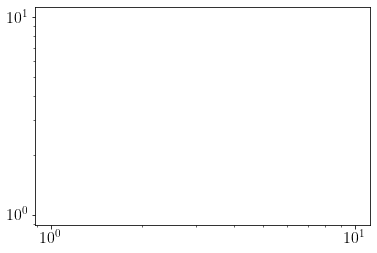

In [194]:
plt.xscale('log')
plt.yscale('log')
compas_data.setGridAndMassEvolved()
print(compas_data.totalMassEvolvedPerZ)
# plt.plot(metallicities, compas_data.totalMassEvolvedPerZ)

In [339]:
def bin_data(data, rates = None, num_bins=100):

    # The lower bounds for each bin
    bin_lower = np.linspace(min(data), max(data), num=num_bins)

    # The "width" of the bin
    dx = bin_lower[1] - bin_lower[0]

    # The 2d array of the bins
    x = [[] for j in range(num_bins)]
    
    # Check if the data has rates attributed to each x value
    if rates is None:

        # Sort each data point into its bin
        index = 0
        for pt in data:
            for lower in bin_lower:
                if lower <= pt and pt < lower + dx:
                    x[index].append(pt)
                    index=0
                    break
                else:
                    index+=1
    else:
        
        # Sort each data point and rate into its bin
        binned_rates = [[] for j in range(num_bins)]

        for data_index, pt in enumerate(data):
            for bin_index, lower in enumerate(bin_lower):
                if lower <= pt and pt < lower + dx:
                    x[bin_index].append(pt)
                    binned_rates[bin_index].append(rates[data_index])

                    break

    # Return all the data
    bins = bin_lower + 0.5*dx
    if rates is None:
        return bins, x
    else:
        return bins, x, binned_rates

def sum1d(data):
    summed = np.zeros(len(data))
    for index, col in enumerate(data):
        summed[index] = np.sum(col)

    return summed

def avg1d(data):
    avged = np.zeros(len(data))
    for index, col in enumerate(data):
        avged[index] = np.average(col)

    return avged

def get_formation_rate_total(binned_log10metallicities, binned_mass_per_Z):
    formation_rate_total = np.zeros(len(binned_log10metallicities))
    
    for index in range(len(formation_rate_total)):
        if len(binned_mass_per_Z) == 0:
            formation_rate_total[index] = 0
        else:
            formation_rate_total[index] = np.divide(len(binned_log10metallicities[index]), np.sum(binned_mass_per_Z[index]))
    
    return formation_rate_total
    

In [338]:
print(len(binned_log10metallicities[-3]))
print(len(binned_mass_per_Z[-3]))

6569
6569


In [325]:
bins, binned_log10metallicities, binned_mass_per_Z = bin_data(np.log10(data[alpha_val][beta_val].metallicityGrid), data[alpha_val][beta_val].totalMassEvolvedPerZ)
# print( binned_mass_per_Z[0])
# print(n)
np.sum(binned_mass_per_Z, axis=1)
# print(np.shape(binned_mass_per_Z[0]))

/Users/adamboesky/opt/anaconda3/envs/PRISE/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


AxisError: axis 1 is out of bounds for array of dimension 1

In [311]:
print(binned_mass_per_Z[0][0])
print(data[alpha_val][beta_val].totalMassEvolvedPerZ[0])

-3.9999926269864563
325.59689299615997


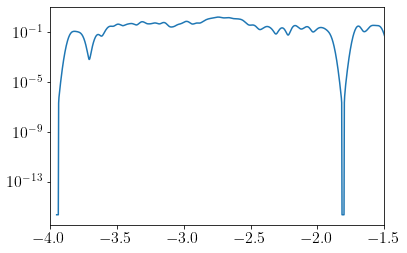

In [412]:
test_data = data['0.1']['0.25']
metallicities = test_data.metallicitySystems
formationRateTotal = np.zeros(len(metallicities))

for nrZ, Z in enumerate(metallicities):
    maskZ = (metallicities == Z)
    formationRateTotal[nrZ] = len(test_data.metallicitySystems[maskZ])

maskZgridinZlist = np.in1d(test_data.metallicityGrid, metallicities)
formationRateTotal = np.divide(formationRateTotal, test_data.totalMassEvolvedPerZ[maskZgridinZlist]) + 0

mass_per_z_axis, mass_per_z_kde = FFTKDE(bw=0.02).fit(np.log10(metallicities), formationRateTotal).evaluate()

plt.yscale('log')
plt.xlim([-4, -1.5])
plt.plot(mass_per_z_axis, mass_per_z_kde)


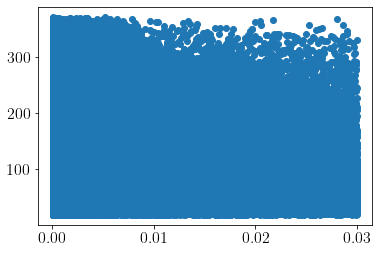

In [401]:
plt.scatter(test_data.metallicityGrid, test_data.totalMassEvolvedPerZ)

In [424]:
print(data['0.1']['0.5'])

[0.0001     0.0001     0.0001     ... 0.02999898 0.02999937 0.02999999]


TypeError: object of type 'NoneType' has no len()

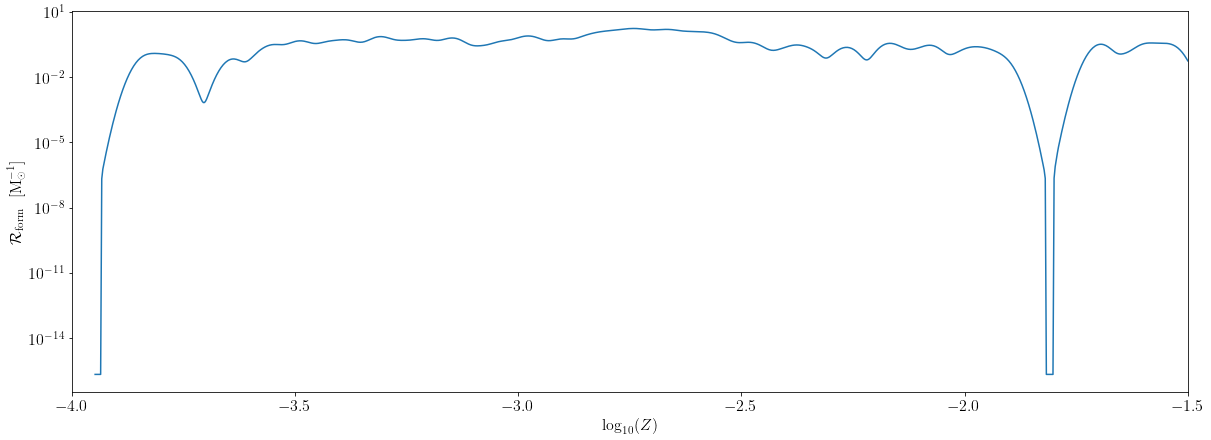

In [426]:
# Declare figure
fig = plt.figure(figsize=(20, 7))
plt.yscale('log')

for alpha_val in alpha_vals:
    for beta_val in beta_vals:
        model_data = data[alpha_val][beta_val]

        # bins, binned_log10metallicities, binned_mass_per_Z = bin_data(np.log10(data[alpha_val][beta_val].metallicityGrid), rates=data[alpha_val][beta_val].totalMassEvolvedPerZ)
        
        # Take the log of the metallicity grid
        # log10metallicities = np.log10(data[alpha_val][beta_val].metallicityGrid)

        # Calculate a KDE with the weights of the metallicities being the total mass evolved at the given Z
        # mass_per_z_axis, mass_per_z_kde = FFTKDE(bw=0.007).fit(log10metallicities, weights=data[alpha_val][beta_val].totalMassEvolvedPerZ).evaluate()

        metallicities = model_data.metallicitySystems
        formationRateTotal = np.zeros(len(metallicities))

        for nrZ, Z in enumerate(metallicities):
            if Z in model_data.metallicityGrid:
                maskZ = (metallicities == Z)
                formationRateTotal[nrZ] = len(metallicities[maskZ])
            else:
                formationRateTotal[nrZ] = 0

        maskZgridinZlist = np.in1d(model_data.metallicityGrid, metallicities)
        formationRateTotal = np.divide(formationRateTotal, model_data.totalMassEvolvedPerZ[maskZgridinZlist]) + 0

        mass_per_z_axis, mass_per_z_kde = FFTKDE(bw=0.02).fit(np.log10(metallicities), weights=formationRateTotal).evaluate()

        # Label and bound axes
        plt.xlabel(r'$\log_{10}(Z)$')
        plt.ylabel(r'$\mathcal{R}_{\rm{form}}  \ \  [\rm{M}_{\odot}^{-1}]$')
        plt.xlim([-4, -1.5])

        # Plot KDE
        plt.plot(mass_per_z_axis, mass_per_z_kde, label=r'$\alpha_{\textrm{CE}} = $' + alpha_val + r'$\beta = $' + beta_val)

plt.legend(loc='upper right', prop={'size': 15})

In [ ]:
# Declare figure
fig = plt.figure(figsize=(20, 7))

for alpha_val in alpha_vals:
    for beta_val in beta_vals:

        # Take the log of the metallicity grid
        log10metallicities = np.log10(data[alpha_val][beta_val].metallicityGrid)

        # Calculate a KDE with the weights of the metallicities being the total mass evolved at the given Z
        mass_per_z_axis, mass_per_z_kde = FFTKDE(bw=0.007).fit(log10metallicities, weights=data[alpha_val][beta_val].totalMassEvolvedPerZ).evaluate()

        # Label and bound axes
        plt.xlabel(r'$\log_{10}(Z)$')
        plt.ylabel(r'$\mathcal{R}_{\rm{form}}  \ \  [\rm{M}_{\odot}^{-1}]$')
        plt.xlim([-4, -1.5])

        # Plot KDE
        plt.plot(mass_per_z_axis, mass_per_z_kde, label=r'$\alpha_{\textrm{CE}} = $' + alpha_val + r'$\beta = $' + beta_val)

plt.legend(loc='upper right', prop={'size': 15})

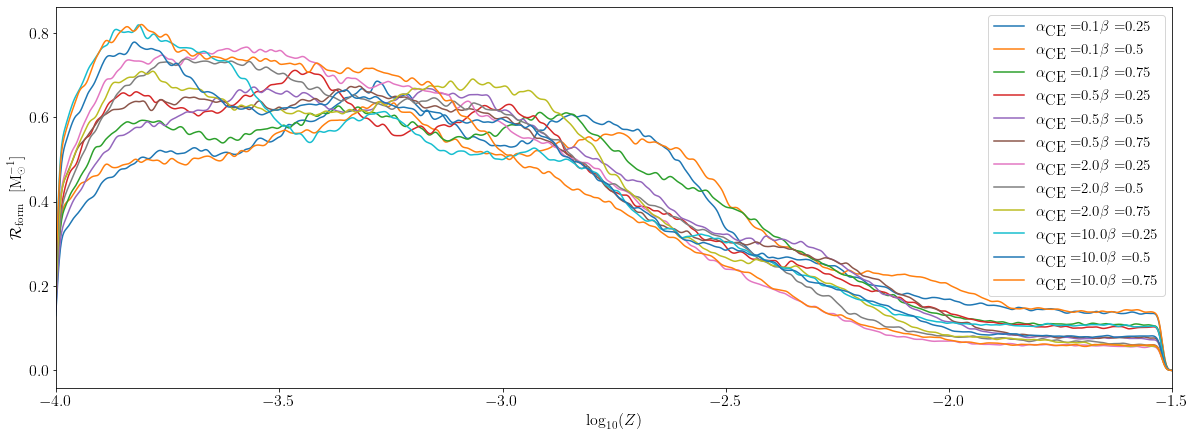

In [283]:
# Declare figure
fig = plt.figure(figsize=(20, 7))

for alpha_val in alpha_vals:
    for beta_val in beta_vals:

        # Take the log of the metallicity grid
        log10metallicities = np.log10(data[alpha_val][beta_val].metallicityGrid)

        # Calculate a KDE with the weights of the metallicities being the total mass evolved at the given Z
        mass_per_z_axis, mass_per_z_kde = FFTKDE(bw=0.007).fit(log10metallicities, weights=data[alpha_val][beta_val].totalMassEvolvedPerZ).evaluate()

        # Label and bound axes
        plt.xlabel(r'$\log_{10}(Z)$')
        plt.ylabel(r'$\mathcal{R}_{\rm{form}}  \ \  [\rm{M}_{\odot}^{-1}]$')
        plt.xlim([-4, -1.5])

        # Plot KDE
        plt.plot(mass_per_z_axis, mass_per_z_kde, label=r'$\alpha_{\textrm{CE}} = $' + alpha_val + r'$\beta = $' + beta_val)

plt.legend(loc='upper right', prop={'size': 15})

In [6]:
maxes = []
mins = []
for alpha_val, beta_dict in bns_chirp_masses.items():
    for beta_val, cms in beta_dict.items():
        # print(cms)
        # print(min(cms))
        maxes.append(max(cms))
        mins.append(min(cms))
print(max(maxes))
print(min(mins))


2.158622591204765
1.0968937097531164


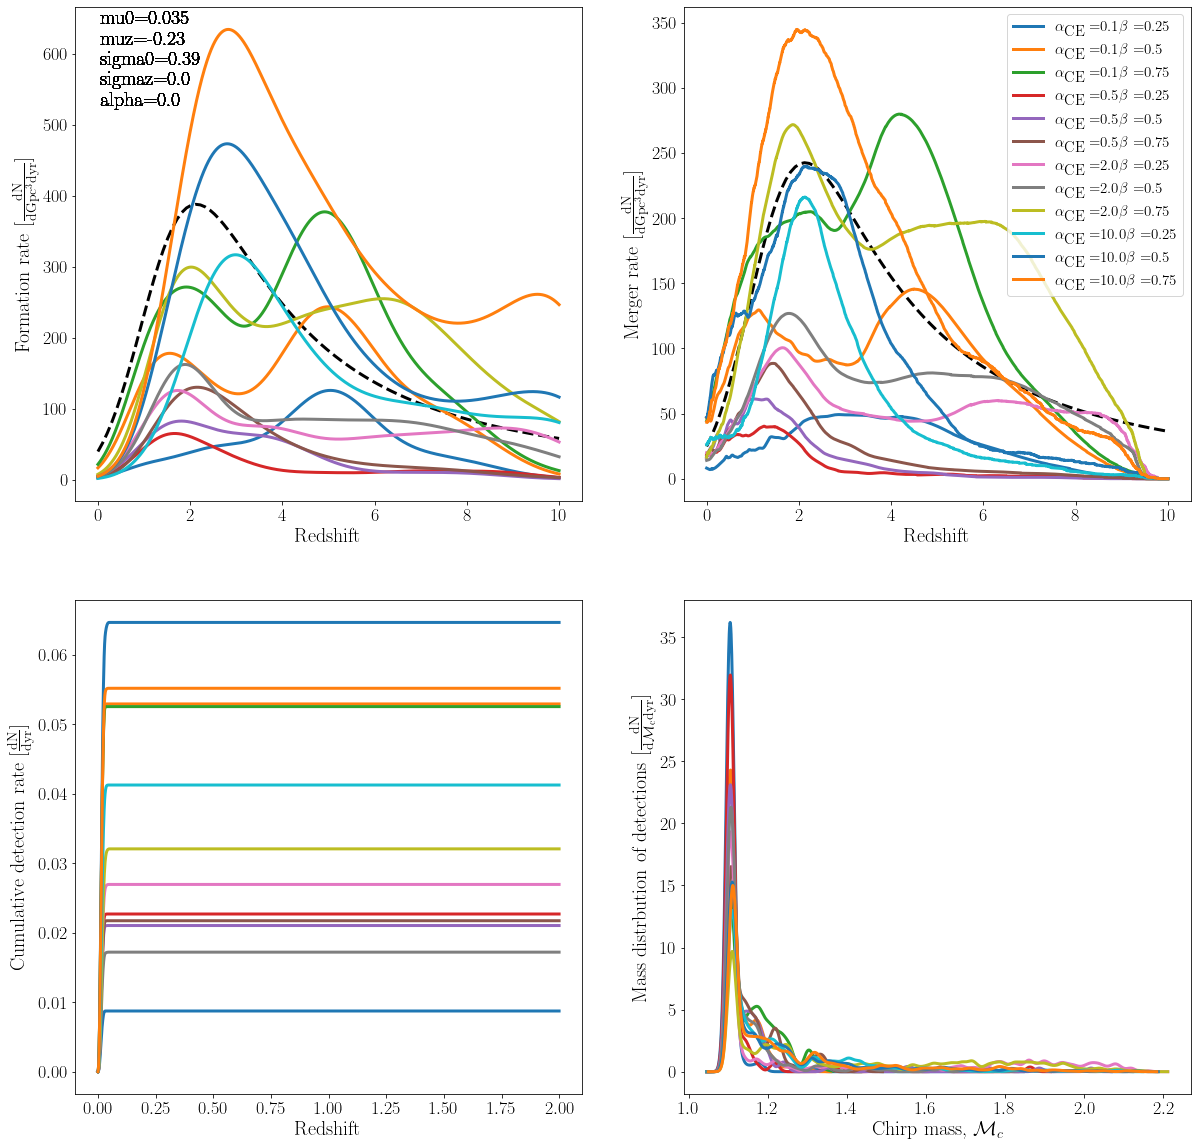

In [237]:
###########################
#Start plotting

# set some constants for the plots
plt.rc('font', family='serif')
fs = 20
lw = 3
fig, axes = plt.subplots(2, 2, figsize=(20, 20))

# Calculate and scare the SFR to plot on the formation and merger rate plots
sfr_redshifts = np.linspace(0, 10, num=100)
sfr = FCI.find_sfr(sfr_redshifts, a = aSF, b = bSF, c = cSF, d = dSF)
formation_rate_sfr = 4 * sfr * 10**(-6)
merger_rate_sfr =  2.5 * sfr * 10**(-6)

# Plot SFRs
axes[0,0].plot(sfr_redshifts, formation_rate_sfr, color='black', lw=lw, linestyle='dashed')
axes[0,1].plot(sfr_redshifts, merger_rate_sfr, color='black', lw=lw, linestyle='dashed')

for alpha_val in alpha_vals:
        for beta_val in beta_vals:

                axes[0,0].plot(bns_redshifts[alpha_val][beta_val], bns_total_formation_rates[alpha_val][beta_val], lw=lw)
                axes[0,0].set_xlabel('Redshift', fontsize=fs)
                axes[0,0].set_ylabel(r'Formation rate $[\rm \frac{\mathrm{d}N}{\mathrm{d}Gpc^3 \mathrm{d}yr}]$', fontsize=fs)

                axes[0,1].plot(bns_redshifts[alpha_val][beta_val], bns_total_merger_rates[alpha_val][beta_val], lw=lw, label=r'$\alpha_{\textrm{CE}} = $' + alpha_val + r'$\beta = $' + beta_val)
                axes[0,1].set_xlabel('Redshift', fontsize=fs)
                axes[0,1].set_ylabel(r'Merger rate $[\rm \frac{\mathrm{d}N}{\mathrm{d}Gpc^3 \mathrm{d}yr}]$', fontsize=fs)
                axes[0,1].legend(loc='upper right', prop={'size': 15})

                axes[1,0].plot(bns_redshifts[alpha_val][beta_val][:len(bns_cumulative_detection_rates[alpha_val][beta_val])], bns_cumulative_detection_rates[alpha_val][beta_val], lw=lw)
                axes[1,0].set_xlabel('Redshift', fontsize=fs)
                axes[1,0].set_ylabel(r'Cumulative detection rate $[\rm \frac{\mathrm{d}N}{\mathrm{d}yr}]$', fontsize=fs)

                bns_axis, bns_mass_kde = FFTKDE(bw=0.01).fit(bns_chirp_masses[alpha_val][beta_val]).evaluate()
                # axes[1,1].hist(chirp_masses[val], weights=detection_rates_by_binary[val], bins=25, range=(min(chirp_masses[val]) - 1, max(chirp_masses[val]) + 1))
                axes[1,1].plot(bns_axis, bns_mass_kde, lw=lw)
                # axes[1,1].set_xlim([1.09, 1.16])        
                axes[1,1].set_xlabel(r'Chirp mass, $\mathcal{M}_c$', fontsize=fs)
                axes[1,1].set_ylabel(r'Mass distrbution of detections $[\rm \frac{\mathrm{d}N}{\mathrm{d}\mathcal{M}_c \mathrm{d}yr}]$', fontsize=fs)

                #########################
                # Plotvalues

                # Add text upper left corner
                axes[0,0].text(0.05,0.8, 
                        "mu0={} \nmuz={} \nsigma0={} \nsigmaz={} \nalpha={}".format(mu0,muz,sigma0,sigmaz,alpha), 
                        transform=axes[0,0].transAxes, size = fs) 

                for ax in axes.flatten():
                        ax.tick_params(labelsize=0.9*fs)
                # Save and show :)
                # plt.savefig(imageDir + "RateInfoHist_mu0{}_muz{}_alpha{}_sigma0{}_sigmaz{}.png".format(mu0, muz, alpha, sigma0, sigmaz), bbox_inches='tight') 

## b) BHNS

In [245]:
dco_type        = "BHNS"

In [246]:
bns_detection_rates = {}
bns_formation_rates = {}
bns_merger_rates = {}
bns_redshifts = {}
bns_COMPASs = {}

for alpha_index, alpha_ce in enumerate(alpha_vals):
    # Make the dictionary "2D"
    bns_detection_rates[alpha_ce] = {}
    bns_formation_rates[alpha_ce] = {}
    bns_merger_rates[alpha_ce] = {}
    bns_redshifts[alpha_ce] = {}
    bns_COMPASs[alpha_ce] = {}

    for beta_index, beta in enumerate(beta_vals):
        bns_detection_rates[alpha_ce][beta], bns_formation_rates[alpha_ce][beta], bns_merger_rates[alpha_ce][beta], bns_redshifts[alpha_ce][beta], bns_COMPASs[alpha_ce][beta] = \
            FCI.find_detection_rate(
            condensed_paths[alpha_ce][beta], dco_type=dco_type, weight_column=weight_column,
            merges_hubble_time=merges_hubble_time, pessimistic_CEE=pessimistic_CEE,
            no_RLOF_after_CEE=no_RLOF_after_CEE, max_redshift=max_redshift,
            max_redshift_detection=max_redshift_detection,
            redshift_step=redshift_step, z_first_SF=z_first_SF,
            m1_min=m1_min, m1_max=m1_max, m2_min=m2_min,
            fbin=fbin, aSF=aSF, bSF=bSF, cSF=cSF, dSF=dSF,
            mu0=mu0, muz=muz, sigma0=sigma0, alpha=alpha,
            min_logZ=min_logZ, max_logZ=max_logZ, step_logZ=step_logZ,
            sensitivity=sensitivity, snr_threshold=snr_threshold,
            Mc_max=Mc_max, Mc_step=Mc_step,
            eta_max=eta_max, eta_step=eta_step,
            snr_max=snr_max, snr_step=snr_step)

/var/folders/2f/vnb6fr7n7g32fwlgp_k3l3sc0000gn/T/ipykernel_39131/2544759858.py:17: UserWarning: Maximum chirp mass used for detectability calculation is below maximum binary chirp mass * (1+maximum redshift for detectability calculation)
  FCI.find_detection_rate(


Average_SF_mass_needed =  234717863.50518775 solMass
Average_SF_mass_needed =  234466813.17535603 solMass
Average_SF_mass_needed =  235019107.38015997 solMass
Average_SF_mass_needed =  234587441.27685317 solMass
Average_SF_mass_needed =  235610508.70500967 solMass
Average_SF_mass_needed =  236336198.8003492 solMass
Average_SF_mass_needed =  235594145.28961614 solMass
Average_SF_mass_needed =  233568517.64815742 solMass
Average_SF_mass_needed =  232595998.4938003 solMass
Average_SF_mass_needed =  236164605.28594124 solMass
Average_SF_mass_needed =  233216961.22905713 solMass
Average_SF_mass_needed =  234437384.45341814 solMass


In [247]:
bns_total_formation_rates = {}
bns_total_merger_rates = {}
bns_total_detection_rates = {}
bns_cumulative_detection_rates = {}
bns_detection_rates_by_binary = {}
bns_chirp_masses = {}

for alpha_index, alpha_val in enumerate(alpha_vals):
    # Make the dictionary "2D"
    bns_total_formation_rates[alpha_val] = {}
    bns_total_merger_rates[alpha_val] = {}
    bns_total_detection_rates[alpha_val] = {}
    bns_cumulative_detection_rates[alpha_val] = {}
    bns_detection_rates_by_binary[alpha_val] = {}
    bns_chirp_masses[alpha_val] = {}

    for beta_index, beta_val in enumerate(beta_vals):
        bns_chirp_masses[alpha_val][beta_val] = (bns_COMPASs[alpha_val][beta_val].mass1*bns_COMPASs[alpha_val][beta_val].mass2)**(3./5.) / (bns_COMPASs[alpha_val][beta_val].mass1 + bns_COMPASs[alpha_val][beta_val].mass2)**(1./5.)

        # sum things up across binaries
        bns_total_formation_rates[alpha_val][beta_val] = np.sum(bns_formation_rates[alpha_val][beta_val], axis=0)
        bns_total_merger_rates[alpha_val][beta_val] = np.sum(bns_merger_rates[alpha_val][beta_val], axis=0)
        bns_total_detection_rates[alpha_val][beta_val] = np.sum(bns_detection_rates[alpha_val][beta_val], axis=0)

        # and across redshifts
        bns_cumulative_detection_rates[alpha_val][beta_val] = np.cumsum(bns_total_detection_rates[alpha_val][beta_val])
        bns_detection_rates_by_binary[alpha_val][beta_val] = np.sum(bns_detection_rates[alpha_val][beta_val], axis=1)

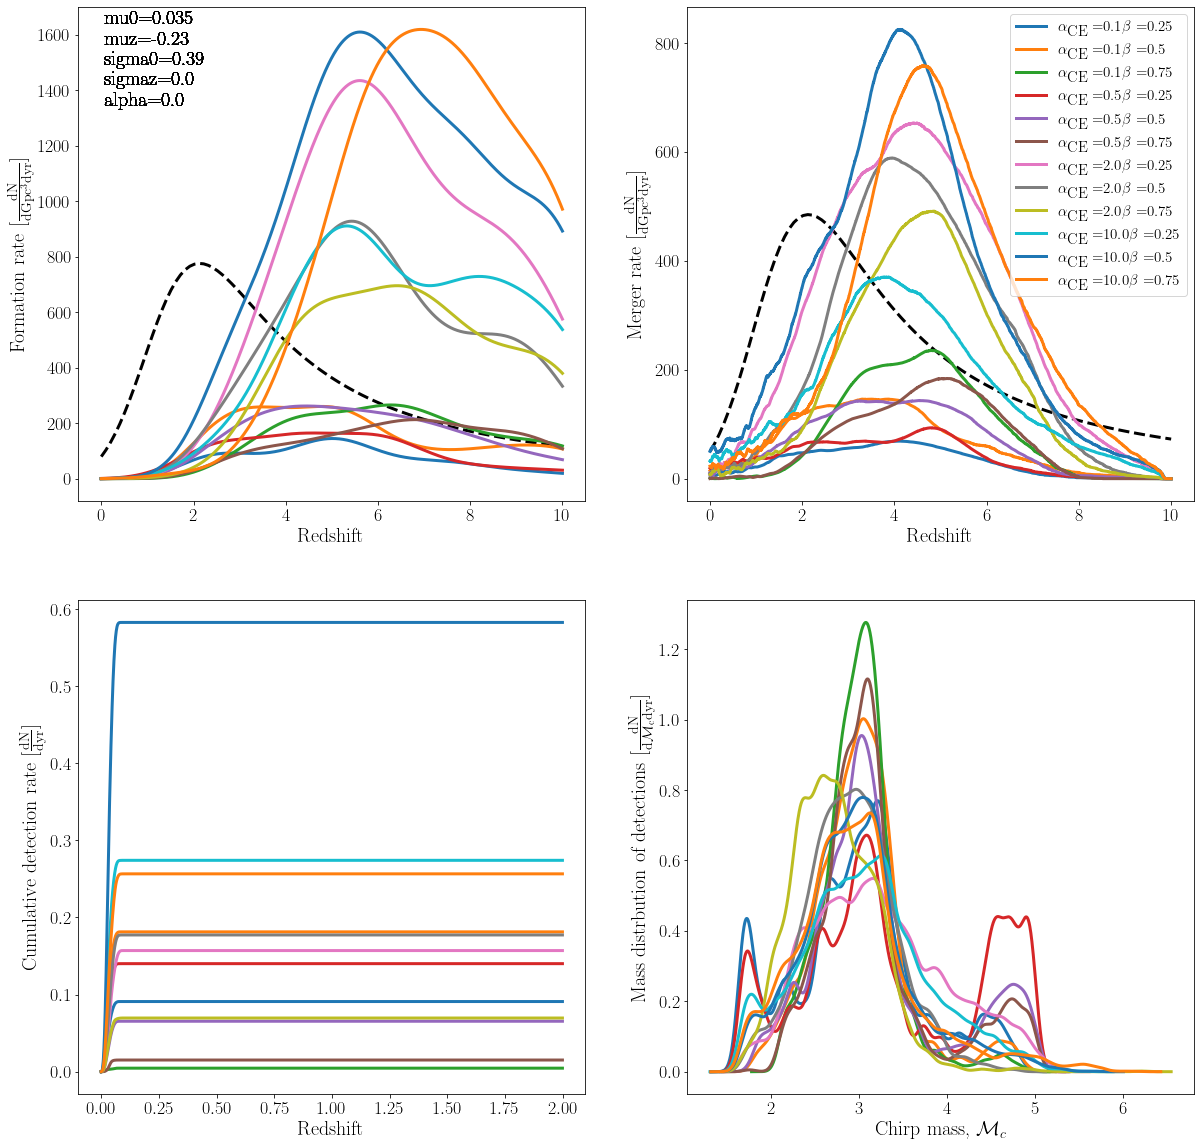

In [248]:
###########################
#Start plotting

# set some constants for the plots
plt.rc('font', family='serif')
fs = 20
lw = 3
fig, axes = plt.subplots(2, 2, figsize=(20, 20))

# Calculate and scare the SFR to plot on the formation and merger rate plots
sfr_redshifts = np.linspace(0, 10, num=100)
sfr = FCI.find_sfr(sfr_redshifts, a = aSF, b = bSF, c = cSF, d = dSF)
formation_rate_sfr = 8 * sfr * 10**(-6)
merger_rate_sfr =  5 * sfr * 10**(-6)

# Plot SFRs
axes[0,0].plot(sfr_redshifts, formation_rate_sfr, color='black', lw=lw, linestyle='dashed')
axes[0,1].plot(sfr_redshifts, merger_rate_sfr, color='black', lw=lw, linestyle='dashed')

for alpha_val in alpha_vals:
        for beta_val in beta_vals:

                axes[0,0].plot(bns_redshifts[alpha_val][beta_val], bns_total_formation_rates[alpha_val][beta_val], lw=lw)
                axes[0,0].set_xlabel('Redshift', fontsize=fs)
                axes[0,0].set_ylabel(r'Formation rate $[\rm \frac{\mathrm{d}N}{\mathrm{d}Gpc^3 \mathrm{d}yr}]$', fontsize=fs)

                axes[0,1].plot(bns_redshifts[alpha_val][beta_val], bns_total_merger_rates[alpha_val][beta_val], lw=lw, label=r'$\alpha_{\textrm{CE}} = $' + alpha_val + r'$ \beta = $' + beta_val)
                axes[0,1].set_xlabel('Redshift', fontsize=fs)
                axes[0,1].set_ylabel(r'Merger rate $[\rm \frac{\mathrm{d}N}{\mathrm{d}Gpc^3 \mathrm{d}yr}]$', fontsize=fs)
                axes[0,1].legend(loc='upper right', prop={'size': 15})

                axes[1,0].plot(bns_redshifts[alpha_val][beta_val][:len(bns_cumulative_detection_rates[alpha_val][beta_val])], bns_cumulative_detection_rates[alpha_val][beta_val], lw=lw)
                axes[1,0].set_xlabel('Redshift', fontsize=fs)
                axes[1,0].set_ylabel(r'Cumulative detection rate $[\rm \frac{\mathrm{d}N}{\mathrm{d}yr}]$', fontsize=fs)

                bns_axis, bns_mass_kde = FFTKDE(bw=0.07).fit(bns_chirp_masses[alpha_val][beta_val]).evaluate()
                # axes[1,1].hist(chirp_masses[val], weights=detection_rates_by_binary[val], bins=25, range=(min(chirp_masses[val]) - 1, max(chirp_masses[val]) + 1))
                axes[1,1].plot(bns_axis, bns_mass_kde, lw=lw)        
                axes[1,1].set_xlabel(r'Chirp mass, $\mathcal{M}_c$', fontsize=fs)
                axes[1,1].set_ylabel(r'Mass distrbution of detections $[\rm \frac{\mathrm{d}N}{\mathrm{d}\mathcal{M}_c \mathrm{d}yr}]$', fontsize=fs)

                #########################
                # Plotvalues

                # Add text upper left corner
                axes[0,0].text(0.05,0.8, 
                        "mu0={} \nmuz={} \nsigma0={} \nsigmaz={} \nalpha={}".format(mu0,muz,sigma0,sigmaz,alpha), 
                        transform=axes[0,0].transAxes, size = fs) 

                for ax in axes.flatten():
                        ax.tick_params(labelsize=0.9*fs)
                # Save and show :)
                # plt.savefig(imageDir + "RateInfoHist_mu0{}_muz{}_alpha{}_sigma0{}_sigmaz{}.png".format(mu0, muz, alpha, sigma0, sigmaz), bbox_inches='tight') 

In [ ]:
import pandas as pd

def Reverse(lst): 
    return [ele for ele in reversed(lst)]


# def plotFormationRatePerZ(pathCSVfile='../dataFiles/summary_data_Fig_1/', alphabetDirDict=alphabetDirDict):
""" plots the formation yield of BHBH, BHNS and NSNS as a function of metallicity
it uses as input the formationRatesTotalAndPerChannel datafiles (see Zenodo for files) that 
should be located in the user-specified directory pathCSVfile 
alphabetDirDict are the names of the simulated data that one wants to plot, 
"""

ncols, nrows = 1, 2  # set figure size and properties
f, ax = plt.subplots(ncols=ncols, nrows=nrows, figsize=(20,20), 
                gridspec_kw={"width_ratios":1*np.ones(ncols), "height_ratios":1*np.ones(nrows)})  

# ## CONSTANTS AND other things 
Types      = ['BHNS',  'BNS']
dictDCOtypeDCOlabel = {'BNS':'NSNS', 'BHNS':'BHNS', 'NSBH':'NSBH'}

# # different marker shape types used 
# nModels = 
# markershapes = ["*", "o", "v",  "p", "H", "^", ">", 'X', "+","<", 'x', "3","d","1", "|", "D", "P", "X", "+", "d"]
# zorderlist = Reverse(range(nModels+3)) # the zorder for the models

# # solar metallicity used to aid the reader 
# solar = 0.0142

# define metallicity array (these are the metallicities of the simulations)
metallicities=[0.0001, 0.00011, 0.00012, 0.00014, 0.00016, 0.00017,\
        0.00019, 0.00022, 0.00024, 0.00027, 0.0003, 0.00034, \
        0.00037, 0.00042, 0.00047, 0.00052, 0.00058, 0.00065,\
        0.00073, 0.00081, 0.0009, 0.00101, 0.00113, 0.00126,\
        0.0014, 0.00157, 0.00175, 0.00195, 0.00218, 0.00243, \
        0.00272, 0.00303, 0.00339, 0.00378, 0.00422, 0.00471, \
        0.00526, 0.00587, 0.00655, 0.00732, 0.00817, 0.00912, \
        0.01018, 0.01137, 0.01269, 0.01416, 0.01581, 0.01765, 0.01971, 0.022, 0.0244, 0.02705, 0.03]
log10metallicities= np.log10(np.asarray(metallicities))

lw, ms=2, 9 # line width and marker size for plots 
y_top=35/1E5  # max Y value to plot 

# axes labels
nameX = r'$\log_{10}(Z)$'
nameY = r'$\mathcal{R}_{\rm{form}}  \ \  [\rm{M}_{\odot}^{-1}]\   $'

# iterate over the different DCO types (BHBH, BHNS and NSNS)
for ind_t, DCOtype in enumerate(Types):
    axe = ax[ind_t] # plot each DCOtype on a new subplot 
    print('now at DCO type  ', DCOtype)
        


        
    DCOname = dictDCOtypeDCOlabel[DCOtype] # label name for DCO type 

    df = pd.DataFrame(np.array(h5py.File(path)['variable_1']))
    df = pd.read_csv(pathCSVfile + 'formationRatesTotalAndPerChannel_'+DCOname+ '_' +  '.csv', index_col=0) # read in data 

    for ind_m, bps_model in enumerate(BPSnameslist):
        
        # label for legend
        if ind_t==0:
            labelname=r'\textbf{%s:} '%bps_model  + alphabetPhysicalNameDict[bps_model] 
        else: 
            labelname=None
        
        
        # key name of the headers in the datafile, we want the 'total' yield that is given in units of Msun for each model
        # the dataframe gives the yield as a list of metallicities 
        key_ =  bps_model + ' ' + 'total'+ '  [Msun^{-1}]'
        upperY = np.asarray(df[key_]) # formation yield per metallicity for this channel 
        

            
        axe.plot(log10metallicities, upperY, color=BPScolors[ind_m], \
                    lw=lw, alpha=1, marker=markershapes[ind_m], markersize=ms,markeredgecolor='k',mew=0.5,\
                        linestyle='-', zorder=zorderlist[ind_m], label=labelname)
        
        
        # add facecolor to indicate regions above and below fiducial (model index 0) formation yields
        if ind_m==0:
            axe.fill_between(log10metallicities, (1E-3/1E5)*np.ones_like(upperY), upperY, color='gray', alpha=0.1)
            axe.fill_between(log10metallicities,  upperY, (100)*np.ones_like(upperY)/1E5,color='gray', alpha=0.4)     

        
    
    if ind_t ==0:  
        # get legend labels
        handles, labels = axe.get_legend_handles_labels()
        

    text_list = [r'$Z=Z_{\odot}$', r'$Z=Z_{\odot}/2$', \
                    r'$Z=Z_{\odot}/5$',  r'$Z=Z_{\odot}/10$',\
                    r'$Z=0.001$', r'$Z=0.0105$']    
    for zz_ind, zz in enumerate([np.log10(solar), \
                                    np.log10(0.5*solar),np.log10(0.2*solar), np.log10(0.1*solar), np.log10(0.001),\
                                    np.log10(0.0105)]) :
        axe.plot([zz,zz], [0,y_top+1/1E5], \
                            c='k',\
                            lw=1.2, alpha=1, linestyle=':', zorder=100)  
        
        # add metallicity values as text to metallicity lines
        if ind_t==0:
            axe.text(zz-0.038, 1.2*0.001/1E5, s=text_list[zz_ind], fontsize=fs, rotation=90, verticalalignment='bottom')
        else:
            axe.text(zz-0.038, y_top-0.5/1E5, s=text_list[zz_ind], fontsize=fs-3, rotation=90, verticalalignment='top')
    
    
    # set axes name  
    axe = layoutAxes(axe, nameX=nameX, nameY=nameY)

    # set yscale and x and y limits 
    axe.set_yscale('log')
    axe.set_xlim(min(log10metallicities), max(log10metallicities))
    axe.set_ylim(bottom=0.001/1E5,top=y_top)

        
    # add box with label to indicate which DCO type we are plotting in the top left of each panel   
    bbox_props = dict(boxstyle="round", fc="w", ec="0.5", alpha=0.95)
    axe.annotate(r'%s'%(DCOname), xy=(0.05, .95), xycoords='axes fraction', fontsize = fs+8, weight = 'bold', ha='left', va="top",bbox=bbox_props)
    
    # add a label for the gray areas in the background 
    if ind_t in [1,2]:
        axe.annotate(r'$\mathcal{R}_{\rm{form}} > \mathcal{R}_{\rm{form}}^{\rm{A:fiducial}} $', xy=(0.03, .79), xycoords='axes fraction', fontsize = fs+2, weight = 'bold', ha='left', va="top")
    if ind_t in [0,1]:
        axe.annotate(r'$\mathcal{R}_{\rm{form}} < \mathcal{R}_{\rm{form}}^{\rm{A:fiducial}} $', xy=(0.03, .1),  xycoords='axes fraction', fontsize = fs+2, weight = 'bold', ha='left', va="top")
        if ind_t==0:
            axe.annotate(r'$\mathcal{R}_{\rm{form}} > \mathcal{R}_{\rm{form}}^{\rm{A:fiducial}} $', xy=(0.82, .95), xycoords='axes fraction', fontsize = fs+2, weight = 'bold', ha='left', va="top")


# add legend, 
plt.tight_layout()
lgd2=plt.legend(handles, labels , fontsize=19, ncol=5,\
        bbox_to_anchor=(0.99, 3.76)) #,  markerscale=3., scatterpoints=1)


# save as png and pdf, 
plt.savefig('./FormationRateAllModels3panels_vertical.png', bbox_extra_artists=(lgd2,), bbox_inches='tight', dpi = 600)
plt.savefig('./FormationRateAllModels3panels_vertical.pdf', bbox_extra_artists=(lgd2,), bbox_inches='tight')
plt.show()
plt.close() 



# plot Figure for Formation yield of DCO mergers as a function of metallicity    
# plotFormationRatePerZ(pathCSVfile='/Users/floorbroekgaarden/Projects/GitHub/Double-Compact-Object-Mergers/dataFiles/summary_data_Fig_1/', alphabetDirDict=alphabetDirDict)    
    


(array([-10.,   0.,  10.,  20.,  30.,  40.,  50.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

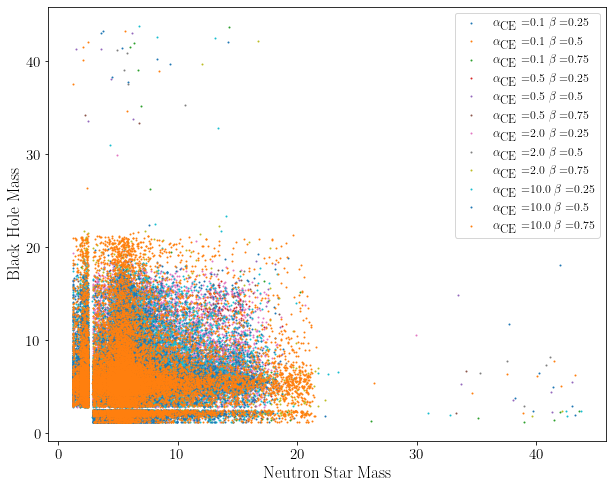

In [134]:
plt.figure(figsize=(10, 8))

for alpha_val in alpha_vals:
        for beta_val in beta_vals:
            f_h5 = h5.File(condensed_paths[alpha_val][beta_val])

            dcos = f_h5['BSE_Double_Compact_Objects']
            dco_seeds = dcos['SEED'][...].squeeze()
            hubble_times = dcos['Merges_Hubble_Time'][...].squeeze()
            times = dcos['Time'][...].squeeze()
            seeds = metallicities = dcos['SEED'][...].squeeze()
            mass1 = dcos['Mass(1)'][...].squeeze()
            mass2 = dcos['Mass(2)'][...].squeeze()
            stype1 = dcos['Stellar_Type(1)'][...].squeeze()
            stype2 = dcos['Stellar_Type(2)'][...].squeeze()
            bhns_mask = np.logical_or(np.logical_and.reduce((stype1 == 13, stype2 == 14)), np.logical_and.reduce((stype1 == 14, stype2 == 13)))
            bhns_seeds = dco_seeds[bhns_mask]

            bhns_mass1 = mass1[bhns_mask]
            bhns_mass2 = mass1[bhns_mask]
            bhns_type1 = stype1[bhns_mask]
            bhns_type2 = stype2[bhns_mask]

            bh_mask1 = bhns_type1 == 14
            ns_mask1 = bhns_type1 == 13
            bh_mask2 = bhns_type2 == 14
            ns_mask2 = bhns_type2 == 13

            ns1_mass = bhns_mass1[ns_mask1]
            ns2_mass = bhns_mass2[ns_mask2]
            bh1_mass = bhns_mass1[bh_mask1]
            bh2_mass = bhns_mass2[bh_mask2]

            ns_masses = np.concatenate((ns1_mass, ns2_mass), axis=0)
            bh_masses = np.concatenate((bh1_mass, bh2_mass), axis=0)

            plt.scatter(ns_masses, bh_masses, s=1, label=r'$\alpha_{\textrm{CE}} = $' + alpha_val + r' $\beta = $' + beta_val)
plt.xlabel('Neutron Star Mass', fontsize=17)
plt.ylabel('Black Hole Mass', fontsize=17)
plt.legend(loc='upper right',  prop={'size': 12})
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)


(array([-5.,  0.,  5., 10., 15., 20., 25., 30., 35., 40., 45.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

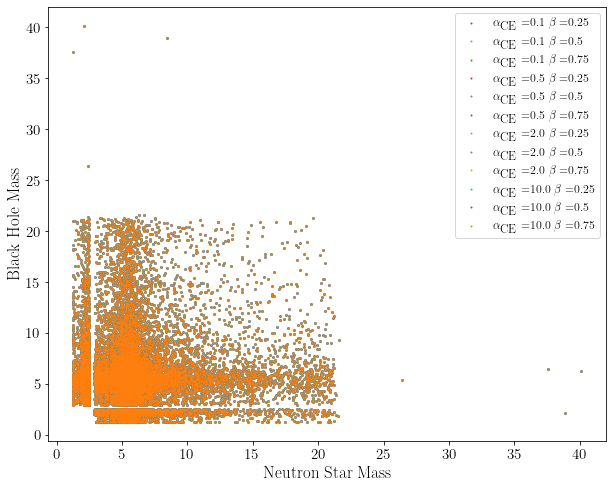

In [135]:
plt.figure(figsize=(10, 8))

for alpha_val in alpha_vals:
        for beta_val in beta_vals:
            f_h5 = h5.File(condensed_paths[alpha_val][beta_val])

            dcos = f_h5['BSE_Double_Compact_Objects']
            dco_seeds = dcos['SEED'][...].squeeze()
            hubble_times = dcos['Merges_Hubble_Time'][...].squeeze()
            times = dcos['Time'][...].squeeze()
            seeds = metallicities = dcos['SEED'][...].squeeze()
            mass1 = dcos['Mass(1)'][...].squeeze()
            mass2 = dcos['Mass(2)'][...].squeeze()
            stype1 = dcos['Stellar_Type(1)'][...].squeeze()
            stype2 = dcos['Stellar_Type(2)'][...].squeeze()
            bhns_mask = np.logical_or(np.logical_and.reduce((stype1 == 13, stype2 == 14)), np.logical_and.reduce((stype1 == 14, stype2 == 13)))
            bhns_seeds = dco_seeds[bhns_mask]

            bhns_masses = np.concatenate((bhns_mass1, bhns_mass2), axis=0)
            bhns_type = np.concatenate((bhns_type1, bhns_type2), axis=0)

            ns_mask = bhns_type==13
            bh_mask = bhns_type==14
            
            ns_masses = bhns_masses[ns_mask]
            bh_masses = bhns_masses[bh_mask]

            plt.scatter(ns_masses, bh_masses, s=1, label=r'$\alpha_{\textrm{CE}} = $' + alpha_val + r' $\beta = $' + beta_val)
plt.xlabel('Neutron Star Mass', fontsize=17)
plt.ylabel('Black Hole Mass', fontsize=17)
plt.legend(loc='upper right',  prop={'size': 12})
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)


## c) BHBH

In [8]:
dco_type        = "BBH"

In [9]:
bns_detection_rates = {}
bns_formation_rates = {}
bns_merger_rates = {}
bns_redshifts = {}
bns_COMPASs = {}

for alpha_index, alpha_ce in enumerate(alpha_vals):
    # Make the dictionary "2D"
    bns_detection_rates[alpha_ce] = {}
    bns_formation_rates[alpha_ce] = {}
    bns_merger_rates[alpha_ce] = {}
    bns_redshifts[alpha_ce] = {}
    bns_COMPASs[alpha_ce] = {}

    for beta_index, beta in enumerate(beta_vals):
        bns_detection_rates[alpha_ce][beta], bns_formation_rates[alpha_ce][beta], bns_merger_rates[alpha_ce][beta], bns_redshifts[alpha_ce][beta], bns_COMPASs[alpha_ce][beta] = \
            FCI.find_detection_rate(
            condensed_paths[alpha_ce][beta], dco_type=dco_type, weight_column=weight_column,
            merges_hubble_time=merges_hubble_time, pessimistic_CEE=pessimistic_CEE,
            no_RLOF_after_CEE=no_RLOF_after_CEE, max_redshift=max_redshift,
            max_redshift_detection=max_redshift_detection,
            redshift_step=redshift_step, z_first_SF=z_first_SF,
            m1_min=m1_min, m1_max=m1_max, m2_min=m2_min,
            fbin=fbin, aSF=aSF, bSF=bSF, cSF=cSF, dSF=dSF,
            mu0=mu0, muz=muz, sigma0=sigma0, alpha=alpha,
            min_logZ=min_logZ, max_logZ=max_logZ, step_logZ=step_logZ,
            sensitivity=sensitivity, snr_threshold=snr_threshold,
            Mc_max=Mc_max, Mc_step=Mc_step,
            eta_max=eta_max, eta_step=eta_step,
            snr_max=snr_max, snr_step=snr_step)

/var/folders/2f/vnb6fr7n7g32fwlgp_k3l3sc0000gn/T/ipykernel_26694/2544759858.py:17: UserWarning: Maximum chirp mass used for detectability calculation is below maximum binary chirp mass * (1+maximum redshift for detectability calculation)
  FCI.find_detection_rate(


Average_SF_mass_needed =  235286927.44397902 solMass
Average_SF_mass_needed =  234656361.9262687 solMass
Average_SF_mass_needed =  235253414.42953998 solMass
Average_SF_mass_needed =  234847495.8294083 solMass


: 

: 

In [ ]:
bns_total_formation_rates = {}
bns_total_merger_rates = {}
bns_total_detection_rates = {}
bns_cumulative_detection_rates = {}
bns_detection_rates_by_binary = {}
bns_chirp_masses = {}

for alpha_index, alpha_val in enumerate(alpha_vals):
    # Make the dictionary "2D"
    bns_total_formation_rates[alpha_val] = {}
    bns_total_merger_rates[alpha_val] = {}
    bns_total_detection_rates[alpha_val] = {}
    bns_cumulative_detection_rates[alpha_val] = {}
    bns_detection_rates_by_binary[alpha_val] = {}
    bns_chirp_masses[alpha_val] = {}

    for beta_index, beta_val in enumerate(beta_vals):
        bns_chirp_masses[alpha_val][beta_val] = (bns_COMPASs[alpha_val][beta_val].mass1*bns_COMPASs[alpha_val][beta_val].mass2)**(3./5.) / (bns_COMPASs[alpha_val][beta_val].mass1 + bns_COMPASs[alpha_val][beta_val].mass2)**(1./5.)

        # sum things up across binaries
        bns_total_formation_rates[alpha_val][beta_val] = np.sum(bns_formation_rates[alpha_val][beta_val], axis=0)
        bns_total_merger_rates[alpha_val][beta_val] = np.sum(bns_merger_rates[alpha_val][beta_val], axis=0)
        bns_total_detection_rates[alpha_val][beta_val] = np.sum(bns_detection_rates[alpha_val][beta_val], axis=0)

        # and across redshifts
        bns_cumulative_detection_rates[alpha_val][beta_val] = np.cumsum(bns_total_detection_rates[alpha_val][beta_val])
        bns_detection_rates_by_binary[alpha_val][beta_val] = np.sum(bns_detection_rates[alpha_val][beta_val], axis=1)

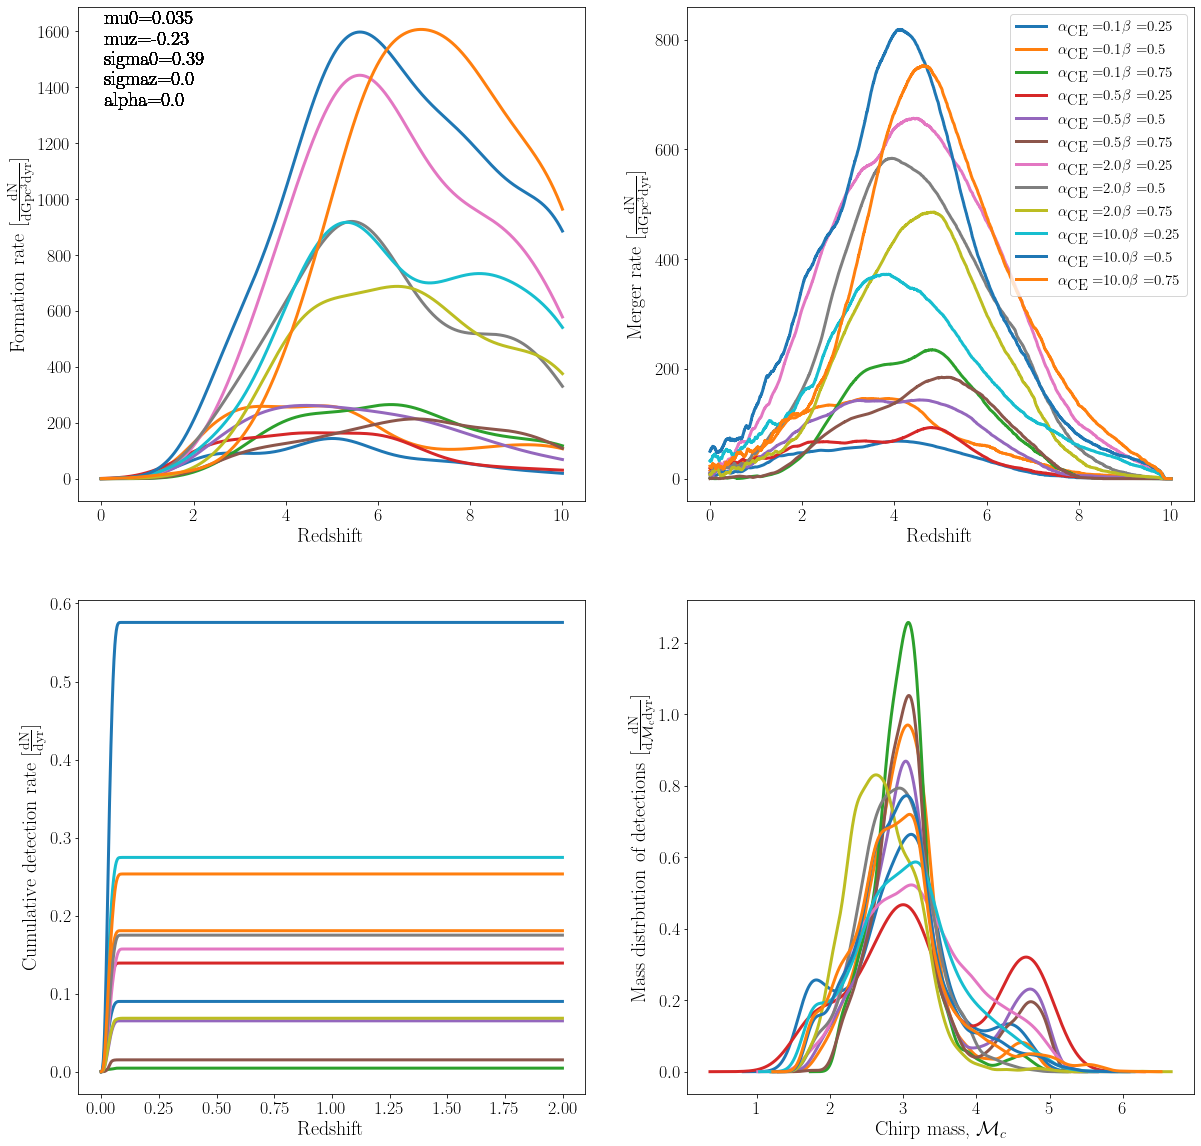

In [ ]:
###########################
#Start plotting

# set some constants for the plots
plt.rc('font', family='serif')
fs = 20
lw = 3
fig, axes = plt.subplots(2, 2, figsize=(20, 20))

for alpha_val in alpha_vals:
        for beta_val in beta_vals:

                axes[0,0].plot(bns_redshifts[alpha_val][beta_val], bns_total_formation_rates[alpha_val][beta_val], lw=lw)
                axes[0,0].set_xlabel('Redshift', fontsize=fs)
                axes[0,0].set_ylabel(r'Formation rate $[\rm \frac{\mathrm{d}N}{\mathrm{d}Gpc^3 \mathrm{d}yr}]$', fontsize=fs)

                axes[0,1].plot(bns_redshifts[alpha_val][beta_val], bns_total_merger_rates[alpha_val][beta_val], lw=lw, label=r'$\alpha_{\textrm{CE}} = $' + alpha_val + r'$\beta = $' + beta_val)
                axes[0,1].set_xlabel('Redshift', fontsize=fs)
                axes[0,1].set_ylabel(r'Merger rate $[\rm \frac{\mathrm{d}N}{\mathrm{d}Gpc^3 \mathrm{d}yr}]$', fontsize=fs)
                axes[0,1].legend(loc='upper right', prop={'size': 15})

                axes[1,0].plot(bns_redshifts[alpha_val][beta_val][:len(bns_cumulative_detection_rates[alpha_val][beta_val])], bns_cumulative_detection_rates[alpha_val][beta_val], lw=lw)
                axes[1,0].set_xlabel('Redshift', fontsize=fs)
                axes[1,0].set_ylabel(r'Cumulative detection rate $[\rm \frac{\mathrm{d}N}{\mathrm{d}yr}]$', fontsize=fs)

                bns_axis, bns_mass_kde = FFTKDE(bw='silverman').fit(bns_chirp_masses[alpha_val][beta_val]).evaluate()
                # axes[1,1].hist(chirp_masses[val], weights=detection_rates_by_binary[val], bins=25, range=(min(chirp_masses[val]) - 1, max(chirp_masses[val]) + 1))
                axes[1,1].plot(bns_axis, bns_mass_kde, lw=lw)        
                axes[1,1].set_xlabel(r'Chirp mass, $\mathcal{M}_c$', fontsize=fs)
                axes[1,1].set_ylabel(r'Mass distrbution of detections $[\rm \frac{\mathrm{d}N}{\mathrm{d}\mathcal{M}_c \mathrm{d}yr}]$', fontsize=fs)

                #########################
                # Plotvalues

                # Add text upper left corner
                axes[0,0].text(0.05,0.8, 
                        "mu0={} \nmuz={} \nsigma0={} \nsigmaz={} \nalpha={}".format(mu0,muz,sigma0,sigmaz,alpha), 
                        transform=axes[0,0].transAxes, size = fs) 

                for ax in axes.flatten():
                        ax.tick_params(labelsize=0.9*fs)
                # Save and show :)
                # plt.savefig(imageDir + "RateInfoHist_mu0{}_muz{}_alpha{}_sigma0{}_sigmaz{}.png".format(mu0, muz, alpha, sigma0, sigmaz), bbox_inches='tight') 

# 3. Metallicity-Delay Time Scatter Plots

## a) BNS

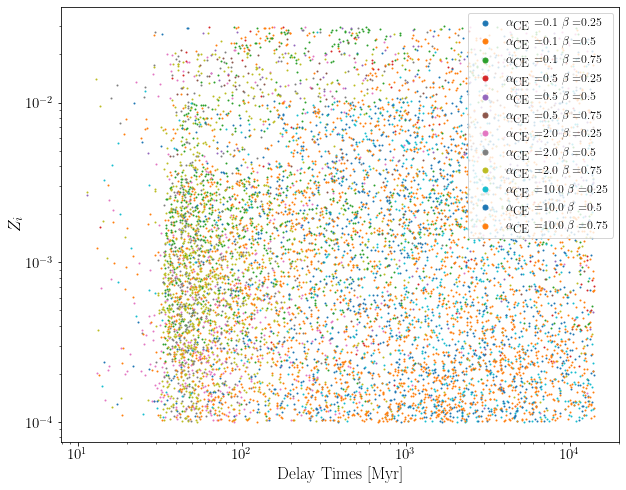

In [46]:
# Declare figsize and yscale
plt.figure(figsize=(10, 8))
plt.yscale("log")  
plt.xscale("log")

# Iterate across alpha_CE-beta grid and plot the delay times versus metallicities
for alpha_val in alpha_vals:
        for beta_val in beta_vals:

            # Get the h5 file
            f_h5 = h5.File(condensed_paths[alpha_val][beta_val])
            
            # Extract the interesting data from the h5 file
            dcos = f_h5['BSE_Double_Compact_Objects']
            sps = f_h5['BSE_System_Parameters']
            dco_seeds = dcos['SEED'][...].squeeze()
            hubble_times = dcos['Merges_Hubble_Time'][...].squeeze()
            t_evolves = dcos['Time'][...].squeeze()
            t_inspirals = dcos['Coalescence_Time'][...].squeeze()
            t_delays = t_evolves + t_inspirals
            sp_seeds = sps['SEED'][...].squeeze()
            metallicities = sps['Metallicity@ZAMS(1)'][...].squeeze()
            stype1 = dcos['Stellar_Type(1)'][...].squeeze()
            stype2 = dcos['Stellar_Type(2)'][...].squeeze()

            # Make some masks
            bns_mask = np.logical_and.reduce((stype1 == 13, stype2 == 13))
            bns_seeds = dco_seeds[bns_mask]
            dco_mask = np.isin(sp_seeds, dco_seeds)

            # Use the masks to extract specific data
            dco_metallicities = metallicities[dco_mask]           # Initial metallicites for just DCO objects
            bns_metallicities = dco_metallicities[bns_mask]       # Initial metallicities for bns objects
            bns_hubble_times = hubble_times[bns_mask]             # Get the hubble_time value for the bns
            bns_t_delays = t_delays[bns_mask]                     # Get the delay times for the bns
            
            # Mask for if the bns merges in hubble time
            merged_mask = bns_hubble_times == 1

            # Get the delay times and metallicities for the bns that merge in hubble time
            bns_delay_times = bns_t_delays[merged_mask]
            bns_merged_metallicities = bns_metallicities[merged_mask]

            # Scatter the bns metallicities over delay times for the bns that merge in hubble time
            plt.scatter(bns_delay_times, bns_merged_metallicities, s=1, label=r'$\alpha_{\textrm{CE}} = $' + alpha_val + r' $\beta = $' + beta_val)

# Label the axes
plt.xlabel('Delay Times [Myr]', fontsize=17)
plt.ylabel(r'$Z_i$', fontsize=17)

# Adjust tick size
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

# Insert a legend
plt.legend(loc='upper right',  prop={'size': 12}, markerscale=5)

# Show the figure!
plt.show()

## b) BHNS

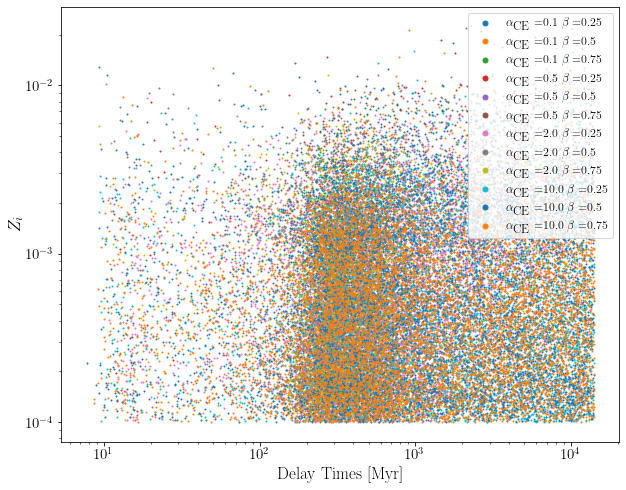

In [47]:
# Declare figsize and yscale
plt.figure(figsize=(10, 8))
plt.yscale("log")  
plt.xscale("log")

# Iterate across alpha_CE-beta grid and plot the delay times versus metallicities
for alpha_val in alpha_vals:
        for beta_val in beta_vals:

            # Get the h5 file
            f_h5 = h5.File(condensed_paths[alpha_val][beta_val])
            
            # Extract the interesting data from the h5 file
            dcos = f_h5['BSE_Double_Compact_Objects']
            sps = f_h5['BSE_System_Parameters']
            dco_seeds = dcos['SEED'][...].squeeze()
            hubble_times = dcos['Merges_Hubble_Time'][...].squeeze()
            t_evolves = dcos['Time'][...].squeeze()
            t_inspirals = dcos['Coalescence_Time'][...].squeeze()
            t_delays = t_evolves + t_inspirals
            sp_seeds = sps['SEED'][...].squeeze()
            metallicities = sps['Metallicity@ZAMS(1)'][...].squeeze()
            stype1 = dcos['Stellar_Type(1)'][...].squeeze()
            stype2 = dcos['Stellar_Type(2)'][...].squeeze()

            # Make some masks
            bhns_mask = np.logical_or(np.logical_and.reduce((stype1 == 13, stype2 == 14)), np.logical_and.reduce((stype1 == 14, stype2 == 13)))
            bhns_seeds = dco_seeds[bhns_mask]
            dco_mask = np.isin(sp_seeds, dco_seeds)

            # Use the masks to extract specific data
            dco_metallicities = metallicities[dco_mask]             # Initial metallicites for just DCO objects
            bhns_metallicities = dco_metallicities[bhns_mask]       # Initial metallicities for bhns objects
            bhns_hubble_times = hubble_times[bhns_mask]             # Get the hubble_time value for the bhns
            bhns_t_delays = t_delays[bhns_mask]                     # Get the delay times for the BHNS
            
            # Mask for if the bhns merges in hubble time
            merged_mask = bhns_hubble_times == 1

            # Get the delay times and metallicities for the bhns that merge in hubble time
            bhns_delay_times = bhns_t_delays[merged_mask]
            bhns_merged_metallicities = bhns_metallicities[merged_mask]

            # Scatter the bhns metallicities over delay times for the bhns that merge in hubble time
            plt.scatter(bhns_delay_times, bhns_merged_metallicities, s=1, label=r'$\alpha_{\textrm{CE}} = $' + alpha_val + r' $\beta = $' + beta_val)

# Label the axes
plt.xlabel('Delay Times [Myr]', fontsize=17)
plt.ylabel(r'$Z_i$', fontsize=17)

# Adjust tick size
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

# Insert a legend
plt.legend(loc='upper right',  prop={'size': 12}, markerscale=5)

# Show the figure!
plt.show()

## c) BBH

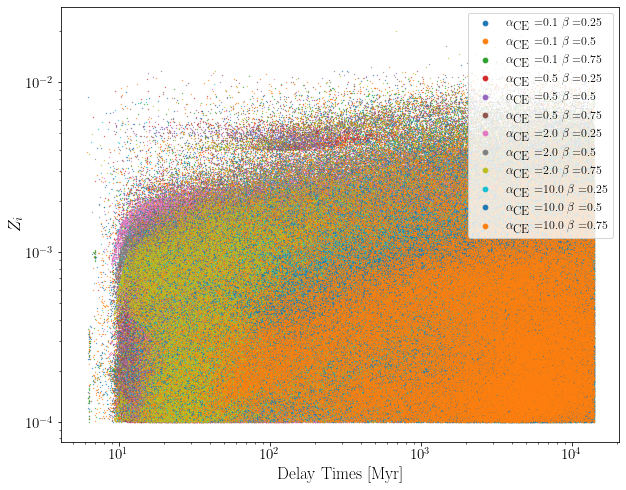

In [48]:
# Declare figsize and yscale
plt.figure(figsize=(10, 8))
plt.yscale("log")  
plt.xscale("log")

# Iterate across alpha_CE-beta grid and plot the delay times versus metallicities
for alpha_val in alpha_vals:
        for beta_val in beta_vals:

            # Get the h5 file
            f_h5 = h5.File(condensed_paths[alpha_val][beta_val])
            
            # Extract the interesting data from the h5 file
            dcos = f_h5['BSE_Double_Compact_Objects']
            sps = f_h5['BSE_System_Parameters']
            dco_seeds = dcos['SEED'][...].squeeze()
            hubble_times = dcos['Merges_Hubble_Time'][...].squeeze()
            t_evolves = dcos['Time'][...].squeeze()
            t_inspirals = dcos['Coalescence_Time'][...].squeeze()
            t_delays = t_evolves + t_inspirals
            sp_seeds = sps['SEED'][...].squeeze()
            metallicities = sps['Metallicity@ZAMS(1)'][...].squeeze()
            stype1 = dcos['Stellar_Type(1)'][...].squeeze()
            stype2 = dcos['Stellar_Type(2)'][...].squeeze()

            # Make some masks
            bbh_mask = np.logical_and.reduce((stype1 == 14, stype2 == 14))
            bbh_seeds = dco_seeds[bbh_mask]
            dco_mask = np.isin(sp_seeds, dco_seeds)

            # Use the masks to extract specific data
            dco_metallicities = metallicities[dco_mask]           # Initial metallicites for just DCO objects
            bbh_metallicities = dco_metallicities[bbh_mask]       # Initial metallicities for bbh objects
            bbh_hubble_times = hubble_times[bbh_mask]             # Get the hubble_time value for the bbh
            bbh_t_delays = t_delays[bbh_mask]                     # Get the delay times for the bbh
            
            # Mask for if the bbh merges in hubble time
            merged_mask = bbh_hubble_times == 1

            # Get the delay times and metallicities for the bbh that merge in hubble time
            bbh_delay_times = bbh_t_delays[merged_mask]
            bbh_merged_metallicities = bbh_metallicities[merged_mask]

            # Scatter the bbh metallicities over delay times for the bbh that merge in hubble time
            plt.scatter(bbh_delay_times, bbh_merged_metallicities, s=0.1, label=r'$\alpha_{\textrm{CE}} = $' + alpha_val + r' $\beta = $' + beta_val)

# Label the axes
plt.xlabel('Delay Times [Myr]', fontsize=17)
plt.ylabel(r'$Z_i$', fontsize=17)

# Adjust tick size
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

# Insert a legend
legend = plt.legend(loc='upper right',  prop={'size': 12}, markerscale=15)

# Show the figure!
plt.show()

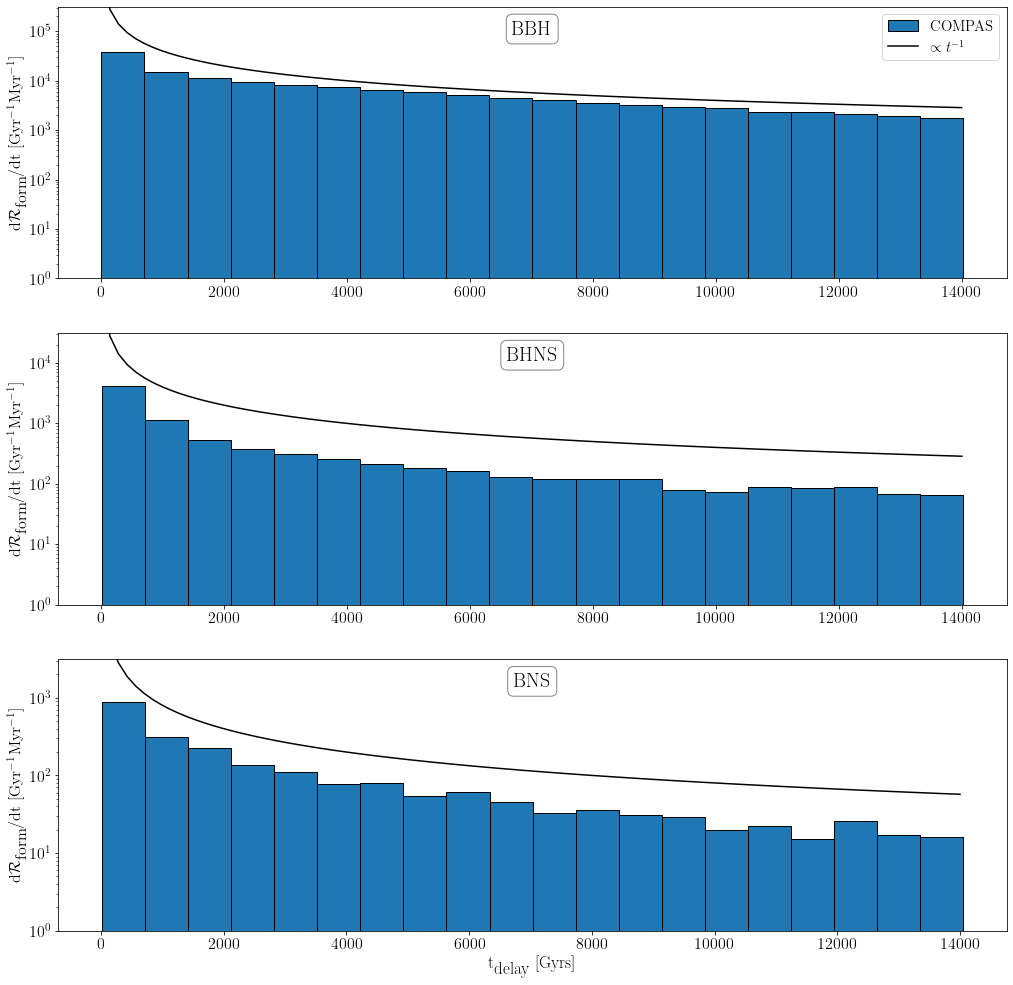

In [119]:
# Adjust fontsize
plt.rcParams['font.size'] = '16'

# Declare figure and subplots
fig, axes = plt.subplots(3, figsize=(17,17))

# Dict of the different data we wish to plot
dco_types = ['BBH', 'BHNS', 'BNS']
delay_time_lists = {'BBH': bbh_delay_times, 'BHNS': bhns_delay_times, 'BNS': bns_delay_times}

# Calculate the lines proportional to t^-1
x = np.linspace(1, 14000, num=100)
ys = {'BBH': 40000000*x**(-1), 'BHNS': 4000000*x**(-1), 'BNS': 800000*x**(-1)}

for index, dco_type in enumerate(dco_types):
    for alpha_val in alpha_vals:
        for beta_val in beta_vals:
            # Get the h5 file
            f_h5 = h5.File(condensed_paths[alpha_val][beta_val])
            
            # Extract the interesting data from the h5 file
            dcos = f_h5['BSE_Double_Compact_Objects']
            sps = f_h5['BSE_System_Parameters']
            dco_seeds = dcos['SEED'][...].squeeze()
            hubble_times = dcos['Merges_Hubble_Time'][...].squeeze()
            t_evolves = dcos['Time'][...].squeeze()
            t_inspirals = dcos['Coalescence_Time'][...].squeeze()
            t_delays = t_evolves + t_inspirals
            sp_seeds = sps['SEED'][...].squeeze()
            metallicities = sps['Metallicity@ZAMS(1)'][...].squeeze()
            stype1 = dcos['Stellar_Type(1)'][...].squeeze()
            stype2 = dcos['Stellar_Type(2)'][...].squeeze()

            # Make some masks
            bbh_mask = np.logical_and.reduce((stype1 == 14, stype2 == 14))
            bbh_seeds = dco_seeds[bbh_mask]
            dco_mask = np.isin(sp_seeds, dco_seeds)

            # Use the masks to extract specific data
            dco_metallicities = metallicities[dco_mask]           # Initial metallicites for just DCO objects
            bbh_metallicities = dco_metallicities[bbh_mask]       # Initial metallicities for bbh objects
            bbh_hubble_times = hubble_times[bbh_mask]             # Get the hubble_time value for the bbh
            bbh_t_delays = t_delays[bbh_mask]                     # Get the delay times for the bbh
            
            # Mask for if the bbh merges in hubble time
            merged_mask = bbh_hubble_times == 1

            # Get the delay times and metallicities for the bbh that merge in hubble time
            bbh_delay_times = bbh_t_delays[merged_mask]
            bbh_merged_metallicities = bbh_metallicities[merged_mask]


            delay_time_bins = np.linspace(min(delay_time_lists[dco_type]), max(delay_time_lists[dco_type]), 20)
            np.histogram(delay_time_lists, )
            bns_formation_rates[alpha_val][beta_val]

    # Set y scale
    axes[index].set_yscale('log')

    # Make histogram of the delay times
    axes[index].hist(delay_time_lists[dco_type], bins=20, label='COMPAS', edgecolor='black')

    # Plot the lines proportional to t^-1
    axes[index].plot(x, ys[dco_type], color='black', label=r'$\propto t^{-1}$')
    axes[index].set(ylabel=r'd$\mathcal{R}_{\textrm{form}}$/dt [Gyr$^{-1}$Myr$^{-1}$]')
    
    # Add box with label to indicate which DCO type we are plotting in the top left of each panel   
    bbox_props = dict(boxstyle="round", fc="w", ec="0.5", alpha=0.95)
    axes[index].annotate(r'%s'%(dco_type), xy=(0.5, .95), xycoords='axes fraction', fontsize = 20, weight = 'bold', ha='center', va="top",bbox=bbox_props)

# Add legend to the top panel
axes[0].legend(loc='upper right', prop={'size': 15})

# Set y limits for each plot
axes[0].set_ylim(1, 10**5.5)
axes[1].set_ylim(1, 10**4.5)
axes[2].set_ylim(1, 10**3.5)

# Make the x label for the plots
plt.xlabel(r't$_{\textrm{delay}}$ [Gyrs]', fontsize=17)

# Show the plot!
plt.show()

In [ ]:
# Adjust fontsize
plt.rcParams['font.size'] = '16'

# Declare figure and subplots
fig, axes = plt.subplots(3, figsize=(17,17))

# Dict of the different data we wish to plot
dco_types = ['BBH', 'BHNS', 'BNS']
delay_time_lists = {'BBH': bbh_delay_times, 'BHNS': bhns_delay_times, 'BNS': bns_delay_times}

# Calculate the lines proportional to t^-1
x = np.linspace(1, 14000, num=100)
ys = {'BBH': 40000000*x**(-1), 'BHNS': 4000000*x**(-1), 'BNS': 800000*x**(-1)}

for index, dco_type in enumerate(dco_types):
    for alpha_val in alpha_vals:
        for beta_val in beta_vals:
            # Get the h5 file
            f_h5 = h5.File(condensed_paths[alpha_val][beta_val])
            
            # Extract the interesting data from the h5 file
            dcos = f_h5['BSE_Double_Compact_Objects']
            sps = f_h5['BSE_System_Parameters']
            dco_seeds = dcos['SEED'][...].squeeze()
            hubble_times = dcos['Merges_Hubble_Time'][...].squeeze()
            t_evolves = dcos['Time'][...].squeeze()
            t_inspirals = dcos['Coalescence_Time'][...].squeeze()
            t_delays = t_evolves + t_inspirals
            sp_seeds = sps['SEED'][...].squeeze()
            metallicities = sps['Metallicity@ZAMS(1)'][...].squeeze()
            stype1 = dcos['Stellar_Type(1)'][...].squeeze()
            stype2 = dcos['Stellar_Type(2)'][...].squeeze()

            # Make some masks
            bbh_mask = np.logical_and.reduce((stype1 == 14, stype2 == 14))
            bbh_seeds = dco_seeds[bbh_mask]
            dco_mask = np.isin(sp_seeds, dco_seeds)

            # Use the masks to extract specific data
            dco_metallicities = metallicities[dco_mask]           # Initial metallicites for just DCO objects
            bbh_metallicities = dco_metallicities[bbh_mask]       # Initial metallicities for bbh objects
            bbh_hubble_times = hubble_times[bbh_mask]             # Get the hubble_time value for the bbh
            bbh_t_delays = t_delays[bbh_mask]                     # Get the delay times for the bbh
            
            # Mask for if the bbh merges in hubble time
            merged_mask = bbh_hubble_times == 1

            # Get the delay times and metallicities for the bbh that merge in hubble time
            bbh_delay_times = bbh_t_delays[merged_mask]
            bbh_merged_metallicities = bbh_metallicities[merged_mask]


            delay_time_bins = np.linspace(min(bbh_delay_times), max(bbh_delay_times), 20)
            np.histogram(bbh_delay_times, delay_time_bins)
            bns_formation_rates[alpha_val][beta_val]

    # Set y scale
    axes[index].set_yscale('log')

    # Make histogram of the delay times
    axes[index].hist(delay_time_lists[dco_type], bins=20, label='COMPAS', edgecolor='black')

    # Plot the lines proportional to t^-1
    axes[index].plot(x, ys[dco_type], color='black', label=r'$\propto t^{-1}$')
    axes[index].set(ylabel=r'd$\mathcal{R}_{\textrm{form}}$/dt [Gyr$^{-1}$Myr$^{-1}$]')
    
    # Add box with label to indicate which DCO type we are plotting in the top left of each panel   
    bbox_props = dict(boxstyle="round", fc="w", ec="0.5", alpha=0.95)
    axes[index].annotate(r'%s'%(dco_type), xy=(0.5, .95), xycoords='axes fraction', fontsize = 20, weight = 'bold', ha='center', va="top",bbox=bbox_props)

# Add legend to the top panel
axes[0].legend(loc='upper right', prop={'size': 15})

# Set y limits for each plot
axes[0].set_ylim(1, 10**5.5)
axes[1].set_ylim(1, 10**4.5)
axes[2].set_ylim(1, 10**3.5)

# Make the x label for the plots
plt.xlabel(r't$_{\textrm{delay}}$ [Gyrs]', fontsize=17)

# Show the plot!
plt.show()